In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from dataclasses import dataclass

sns.set_theme()
sns.set_palette(sns.color_palette('pastel'))

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Libertine'
})

@dataclass
class Sphere:
    center: torch.Tensor
    radius: torch.Tensor


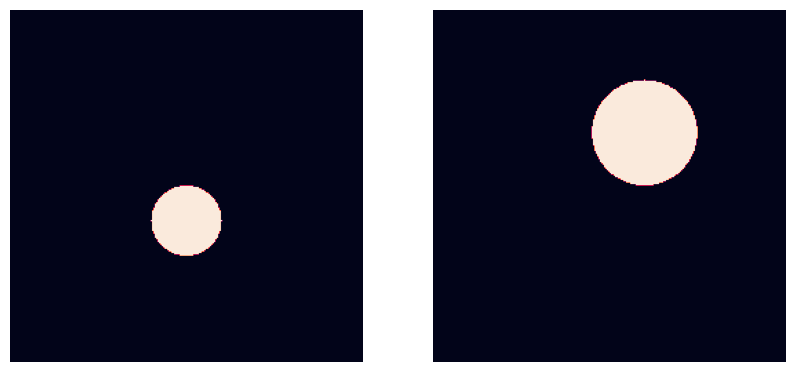

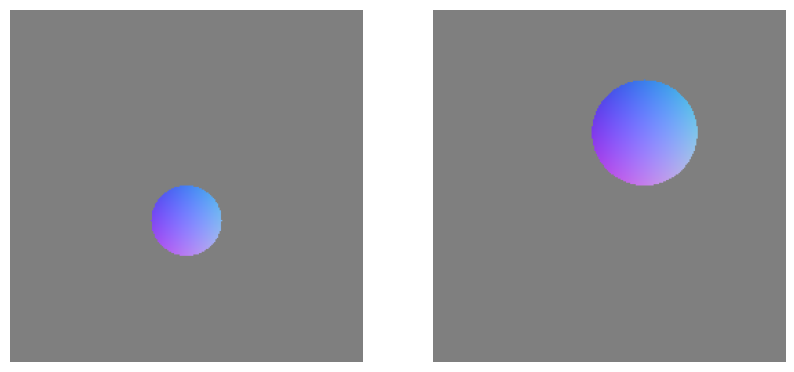

In [2]:
resolution = (256, 256)
extent = (-1.0, 1.0, -1.0, 1.0)
    
target = Sphere(center=torch.Tensor((0.2, 0.0, 0.0)), radius=torch.Tensor((0.2,)))
source = Sphere(center=torch.Tensor((-0.3, 0.2, 0.0)), radius=torch.Tensor((0.3,)))

# Orthogonal projection along z
def render(sphere: Sphere):
    pcenter = sphere.center[:2]
    pradius = sphere.radius
    
    x = torch.linspace(extent[0], extent[1], resolution[0])
    y = torch.linspace(extent[2], extent[3], resolution[1])
    x, y = torch.meshgrid(x, y, indexing='ij')
    xy = torch.stack([x, y], dim=-1)
    
    d = (xy - pcenter).norm(p=2, dim=-1)
    return d < pradius

def normals(sphere: Sphere):
    pcenter = sphere.center[:2]
    radius = sphere.radius

    x = torch.linspace(extent[0], extent[1], resolution[0])
    y = torch.linspace(extent[2], extent[3], resolution[1])
    x, y = torch.meshgrid(x, y, indexing='ij')
    xy = torch.stack((x, y), dim=-1)
    
    d = (xy - pcenter).square().sum(dim=-1)
    z2 = radius - d
    
    z = torch.where(z2 >= 0, z2.sqrt(), 0)
    xyz = torch.cat((xy, z.unsqueeze(-1)), dim=-1)
    
    n = xyz - sphere.center
    nl = n.norm(dim=-1).unsqueeze(-1)
    nl = torch.where(nl == 0, torch.ones_like(nl), nl)
    return n / nl

def render_all():
    target_silhouette = render(target)
    source_silhouette = render(source)

    target_normals = normals(target) * target_silhouette.unsqueeze(-1)
    source_normals = normals(source) * source_silhouette.unsqueeze(-1)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(target_silhouette.detach())
    axs[0].axis('off')

    axs[1].imshow(source_silhouette.detach())
    axs[1].axis('off')
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(0.5 + 0.5 * target_normals.detach())
    axs[0].axis('off')

    axs[1].imshow(0.5 + 0.5 * source_normals.detach())
    axs[1].axis('off')
    plt.show()
    
render_all()

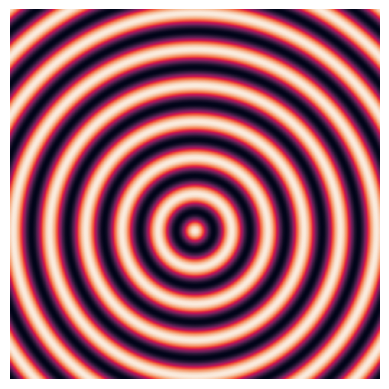

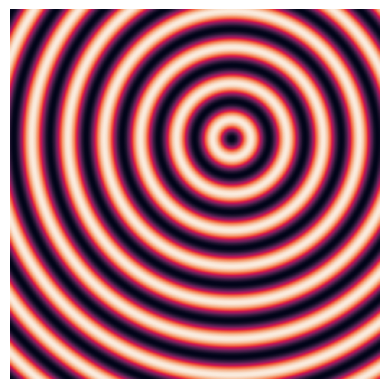

In [3]:
# Silhouette signed distance field
def image_space_sdf(center, radius):
    x = torch.linspace(extent[0], extent[1], resolution[0])
    y = torch.linspace(extent[2], extent[3], resolution[1])
    x, y = torch.meshgrid(x, y, indexing='ij')
    xy = torch.stack([x, y], dim=-1)

    d = (xy - center).norm(dim=-1)
    return d - radius

def projected_sdf(sphere: Sphere, grad=False):
    pcenter = sphere.center[:2]
    pradius = sphere.radius

    pcenter.requires_grad_(grad)
    pradius.requires_grad_(grad)
    
    return image_space_sdf(pcenter, pradius), (pcenter, pradius)

target_projected_sdf, p = projected_sdf(target)
source_projected_sdf, p = projected_sdf(source, grad=True)

plt.imshow((2 ** 5 * target_projected_sdf).cos().detach())
plt.axis('off')
plt.show()

plt.imshow((2 ** 5 * source_projected_sdf).cos().detach())
plt.axis('off')
plt.show()

In [4]:
def slg():
    source_silhouette = render(source)
    source_normals = normals(source) * source_silhouette.unsqueeze(-1)
    
    target_projected_sdf, _ = projected_sdf(target)
    source_projected_sdf, p = projected_sdf(source, grad=True)

    p[0].grad = None
    p[1].grad = None
    loss = (target_projected_sdf - source_projected_sdf).square().mean()
    loss.backward()
    # print(p[0].grad, p[1].grad)

    # U samples
    x = torch.linspace(extent[0], extent[1], resolution[0])
    y = torch.linspace(extent[2], extent[3], resolution[1])
    x, y = torch.meshgrid(x, y, indexing='ij')
    xy = torch.stack([x, y], dim=-1)

    # Find closest point on source (alpha)
    d = (xy - p[0]).norm(dim=-1)
    d = torch.where(d == 0, torch.ones_like(d), d)
    r = (xy - p[0])/d.unsqueeze(-1)
    alpha = p[0] + r * p[1]

    # alphaS = torch.cat((alpha, torch.zeros_like(alpha[..., 0, None])), dim=-1)
    # alphaS = 0.5 + 0.5 * alphaS
    # plt.imshow(alphaS.detach())
    # plt.axis('off')
    # plt.show()

    # Motion vectors
    dalpha = p[0].grad + (alpha - p[0]) * p[1].grad

    # motion = torch.cat((dalpha, torch.zeros_like(dalpha[..., 0, None])), dim=-1)
    # motion = motion * source_silhouette.unsqueeze(-1)
    # motion = 0.5 + 0.5 * motion
    # plt.imshow(motion.detach())
    # plt.axis('off')
    # plt.show()

    # Backprojected and pullback-epd
    bmotion = torch.cat((dalpha, torch.zeros_like(dalpha[..., 0, None])), dim=-1)
    # print('bmotion', bmotion.abs().max())
    elements = source_silhouette.sum()
    dcenter = -bmotion.sum(dim=(0, 1))/elements
    dradius = -(bmotion * source_normals).sum(dim=-1).sum()/elements
    # print('dcenter, dradius', dcenter, dradius)
    
    return dcenter, dradius, loss

100%|██████████| 1000/1000 [00:19<00:00, 51.97it/s]


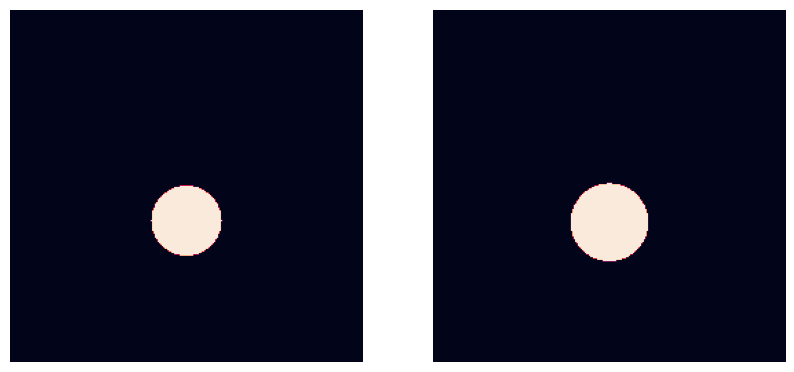

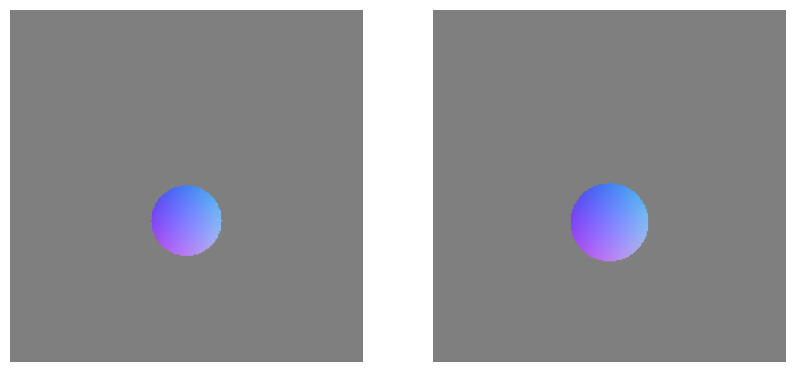

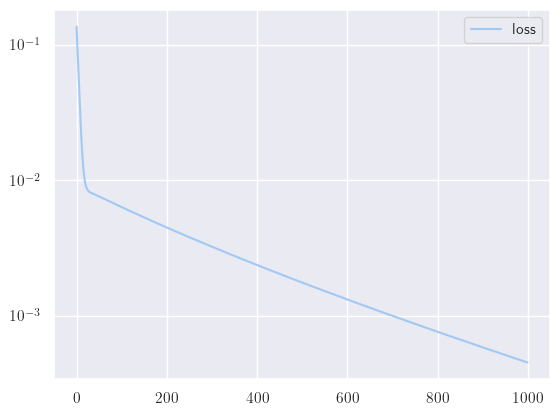

In [5]:
from tqdm import trange

losses = []
for i in trange(1000):
    dcenter, dradius, loss = slg()
    
    losses.append(loss.item())
    with torch.no_grad():
        source.center += 0.01 * dcenter.detach()
        source.radius += 0.01 * dradius.detach()
        
render_all()

plt.plot(losses, label='loss')
plt.yscale('log')
plt.legend()
plt.show()

In [6]:
# for i in range(100):
#     sdf = image_space_sdf(p[0], p[1])
#     loss = (target_projected_sdf - sdf).square().mean()
#     print(loss.item())
#     
#     p[0].grad = p[1].grad = None
#     loss.backward()
#     
#     with torch.no_grad():
#         pcenter = p[0] - 0.01 * p[0].grad
#         pradius = p[1] - 0.01 * p[1].grad
#         pcenter.requires_grad_(True)
#         pradius.requires_grad_(True)
#         p = (pcenter, pradius)
# 
# plt.imshow((2 ** 5 * sdf).cos().detach())
# plt.axis('off')
# plt.show()